# Preprocess data

In [1]:
import csv
import cv2
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
# import sklearn
import random

from os.path import expanduser
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

home_path = expanduser("~")

In [2]:
def data_generator(samples, shape, batch_size, correction, sensitivity, 
                   angle_threshold):
    num_samples = len(samples)
    rows, cols, ch = shape
    factors = [0, 1, -1]
    
    samples = shuffle(samples)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            X = []
            y = []
            for i, sample in enumerate(batch_samples):
                # get steering angle
                angle = float(line[4])
                
                # camera selection
                #  -> drop near-0 angle data with probability
                #  -> [0, 1, 2] = [center, left, right]
                if abs(angle) < angle_threshold and np.random.random() < 0.90:
                    camera = np.random.choice([1, 2])
                else:
                    camera = np.random.choice([0, 1, 2])
                
                adjustment = np.random.uniform(correction-sensitivity, 
                                                   correction+sensitivity)
                
                # adjust angle if needed
                # -> factors[0, 1, -1] = [center, left, right]
                angle += factors[camera] * adjustment

                # read image
                img_path = '../' + sample[camera]
                img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)


                # randomly choose to flip
                if np.random.random() < 0.5:
                    img = np.fliplr(img)
                    angle *= -1
                
                # randomly amend brightness
                # https://discussions.udacity.com/t/still-having-some-issues-with-project-behavioral-cloning-any-advice/234354/45
                if np.random.random() < 0.5:
                    random_bright = .25 + np.random.uniform()
                    
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                    img[:,:,2] = img[:,:,2] * random_bright
                    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
                    img = np.clip(img, 0, 255)
                
                X.append(img)
                y.append(angle)

            yield shuffle(np.array(X), np.array(y))

In [3]:
# read in driving log
samples = []
with open('../data/interim/img/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# drop header
samples = samples[1:-1]

In [4]:
# samples = random.sample(samples, 1000) # 1000 got to dirt corner

x shape = (6, 160, 320, 3)
y shape = (6,)
[ 0.01588996  0.00457633 -0.78095355  0.79565751  0.7607427  -0.03824149]


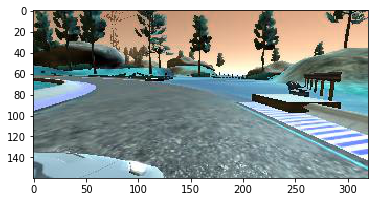

In [5]:
test_generator = data_generator(
    samples[0:10], 
    shape=(160,320,3), 
    batch_size=6, 
    correction=0.38,
    sensitivity=0.02,
    angle_threshold=0.6)

for i in range(1):
    X_batch, y_batch = next(test_generator)
    print('x shape = {}\ny shape = {}'.format(X_batch.shape, y_batch.shape))
    print(y_batch)
    plt.imshow(X_batch[0])
    plt.show()

# Keras modelling

In [6]:
from keras.callbacks import TensorBoard
from keras.layers import Lambda, Cropping2D, MaxPooling2D, Flatten, Dense, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:
# training hyper-parameters
epochs = 20
batch_size = 6

# camera hyper-parameters
correction = 0.25
sensitivity = 0.03
angle_threshold = 0.85

# model hyper-parameters
dropout = 0.15

In [8]:
# set known image attributes
shape = (160, 320, 3)

# set train and validate sets
train_samples, validation_samples = train_test_split(samples, test_size=0.3)
# train_samples, validation_samples = train_test_split(
#     train_samples, test_size=0.2)

# set generator functions
train_generator = data_generator(
    train_samples, 
    shape=shape, 
    batch_size=batch_size, 
    correction=correction,
    sensitivity=sensitivity,
    angle_threshold=angle_threshold)

validation_generator = data_generator(
    validation_samples,
    shape=shape,
    batch_size=batch_size,
    correction=correction,
    sensitivity=sensitivity,
    angle_threshold=angle_threshold)

In [9]:
# model architecture based on
# -> https://arxiv.org/pdf/1604.07316.pdf
model = Sequential()

# region of interest
# Cropping2D((pixels_to_remove_from_top, from_bottom), (0, 0))
model.add(Cropping2D(cropping=((60, 20), (0, 0)), input_shape=shape))

# normalisation
model.add(Lambda(lambda x: x / 255.0 - 0.5))

# Convolution2D(filters, kernel, stride)
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
# model.add(SpatialDropout2D(dropout))
# model.add(Convolution2D(64, 3, 3, activation='elu'))
# model.add(Convolution2D(64, 3, 3, activation='elu'))
# model.add(SpatialDropout2D(dropout))

# flatten
model.add(Flatten())

# fully connected
model.add(Dense(100, activation='elu'))
# model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))

# output
model.add(Dense(1))

In [10]:
model.compile(optimizer=Adam(lr=1e-04), loss='mean_squared_error')

t_board = TensorBoard(
    log_dir='../log', histogram_freq=1, write_graph=True, write_images=True)

history_object = model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples),
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples),
    nb_epoch=epochs,
    verbose=1)

Epoch 1/20
1638/9325 [====>.........................] - ETA: 116s - loss: 0.2131

KeyboardInterrupt: 

In [ ]:
model.save('../model.h5')

In [ ]:
# print the keys contained in the history object
print(history_object.history.keys())

In [ ]:
# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
model.summary()